In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


# Team_MM2_Johannesburg
## Palesa Kheswa
## Tshepo Sibanyoni
## Zamangwane Dithebe
## Thato
## Vuyelwa
## Precious chauke

# Introduction

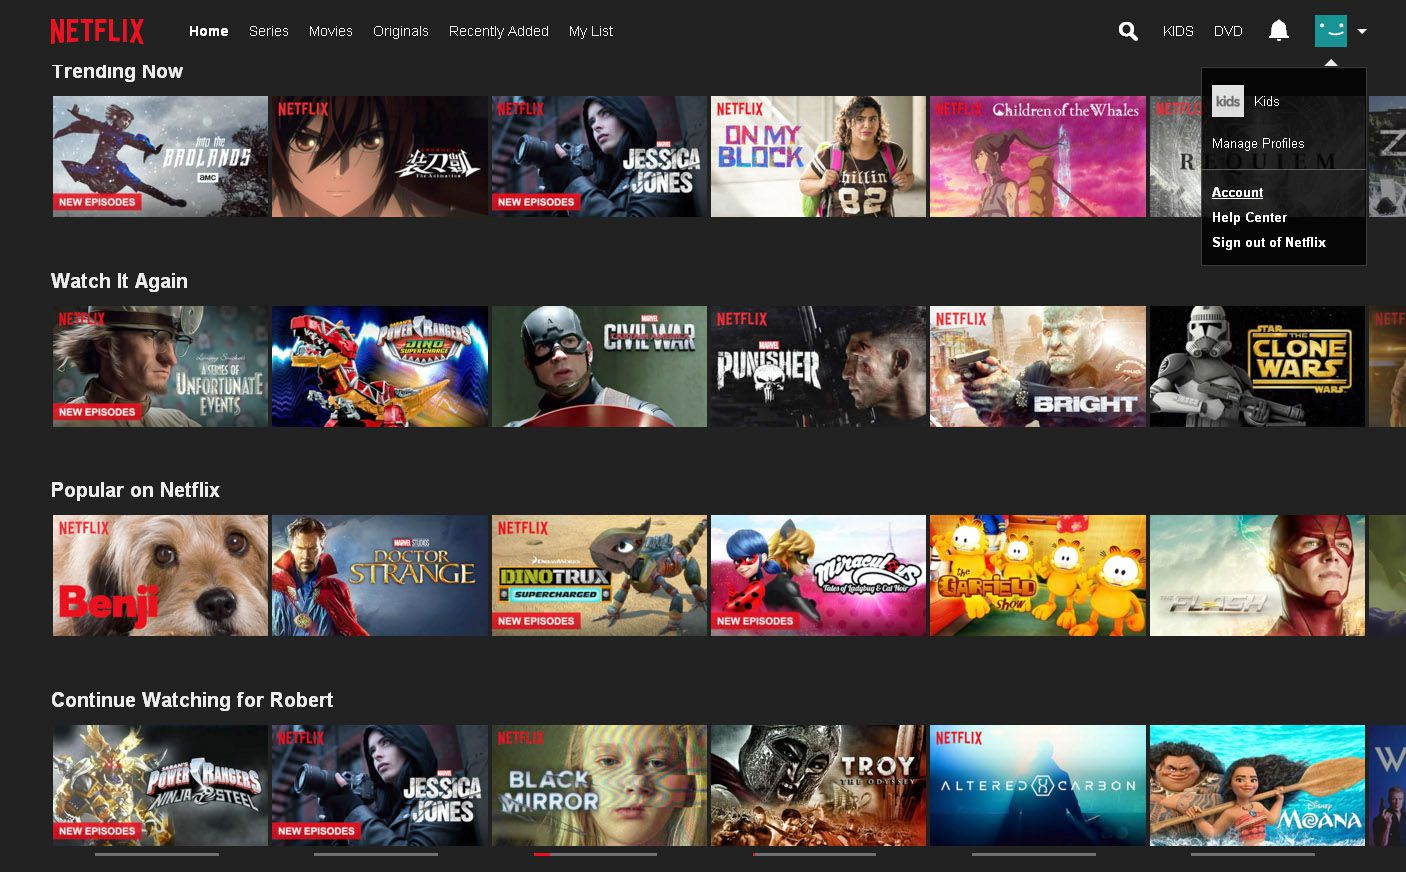

Recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.Recommender systems are among the most popular applications of data science today. They are used to predict the "rating" or "preference" that a user would give to an item.

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play. Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user. They are used to predict the rating or preference that a user would give to an item. Amazon uses it to suggest products to customers, Facebook uses it to recommend pages to like and people to follow. Moreover YouTube, Netflix, Spotify use it to decide which video to play next on autoplay.

# Problem statement
To construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

# Importing python libraries

In [16]:
import pandas as pd 
import numpy as np
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from csv import reader
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
from scipy.sparse import csr_matrix
import scipy as sp
# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from sklearn.cluster import KMeans
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD, BaselineOnly, CoClustering, NMF
import heapq
# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Importing python libraries

In [17]:
sample_submission = pd.read_csv('sample_submission.csv')
movies = pd.read_csv('movies.csv')
imdb = pd.read_csv('imdb_data.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

In [18]:
sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [19]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [20]:
train.shape

(10000038, 4)

In [21]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [34]:
movies.shape

(62423, 3)

In [35]:
movies.describe

<bound method NDFrame.describe of        movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  

In [36]:
dataset=pd.merge(train,movies,on='movieId')

In [37]:
dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [38]:
import datetime
from datetime import datetime,date
dataset['datetime']=pd.to_datetime(dataset['timestamp'])

In [39]:
dataset.shape

(10000038, 7)

In [40]:
dataset.nunique()

userId        162541
movieId        48213
rating            10
timestamp    8795101
title          48151
genres          1558
datetime     8795101
dtype: int64

In [41]:
dataset1=pd.merge(imdb,movies,on='movieId')

In [42]:
dataset1.head()

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy


# EDA

In [15]:
train1 = train.copy()
train1.drop('timestamp', axis = 1, inplace = True)

In [16]:
ratings_per_user = train1.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)

In [17]:
ratings_per_user.head(10)

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


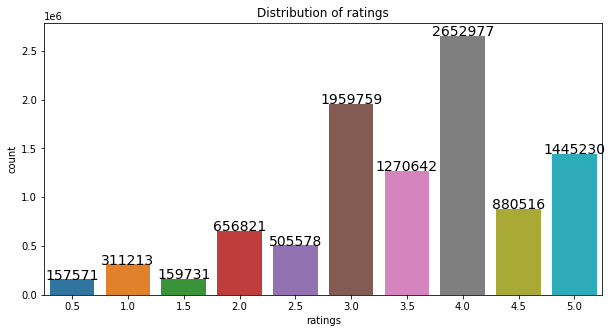

In [20]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=dataset, x='rating')
labels = (train['rating'].value_counts().sort_index())
plt.title('Distribution of ratings')
plt.xlabel('ratings')

for i,v in enumerate(labels):
    ax.text(i, v+100, str(v), horizontalalignment='center', size=14, color='black')
plt.show()

The train distribution shows that there are relatively fewer movies that are lower rated. This can be because most of the users who didn't like the movie, didn't care enough to rate the movie. You should note this, it can be useful later. As you wouldn't want to recommend movies with relatively low number of ratings as users probably didn't like them.

# Most common genres

In [25]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


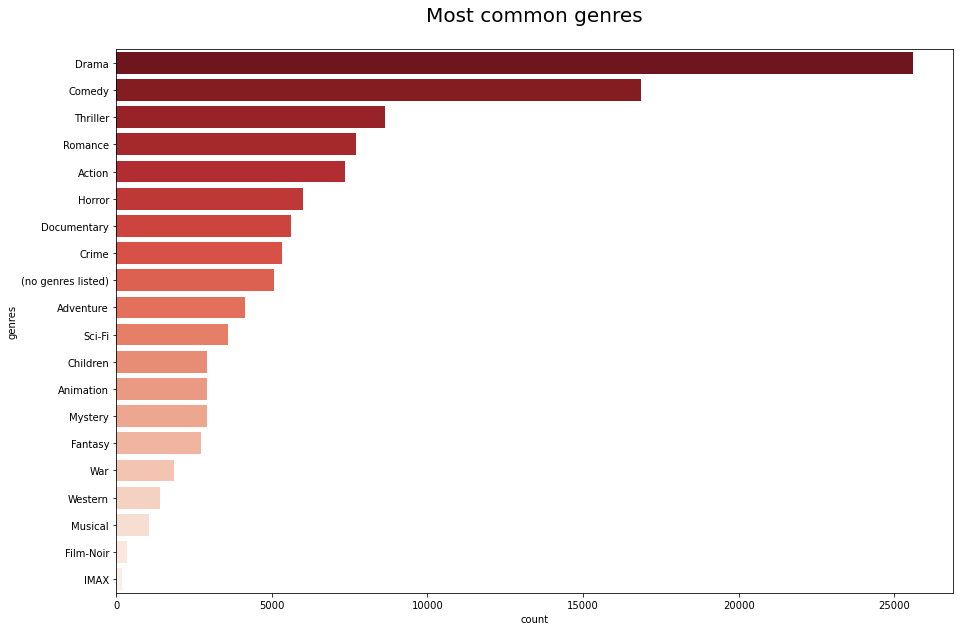

In [26]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

The most common genres are drama,followed by comedy,thriller and romance

# Avarage rating

In [21]:
dataset=dataset.groupby('title')['rating'].mean()
dataset

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    3.000000
"Great Performances" Cats (1998)                           2.753731
#1 Cheerleader Camp (2010)                                 1.900000
#Female Pleasure (2018)                                    4.000000
#FollowMe (2019)                                           2.400000
                                                             ...   
به نام پدر                                                 3.250000
…And the Fifth Horseman Is Fear (1965)                     3.000000
チェブラーシカ (2010)                                             2.000000
貞子3D (2012)                                                2.562500
줄탁동시 (2012)                                                3.000000
Name: rating, Length: 48151, dtype: float64

In [22]:
sorted_train_wise_movies=dataset.sort_values(ascending=False)
sorted_train_wise_movies

title
Which Way Home (2009)                 5.0
Kaakha Kaakha (2003)                  5.0
Not Quite Human II (1989)             5.0
Selling Isobel (2018)                 5.0
Sehar (2005)                          5.0
                                     ... 
Down and Out with the Dolls (2001)    0.5
The Informer (2019)                   0.5
Dough and Dynamite (1914)             0.5
Ideal Husband, An (1947)              0.5
Dopo quella notte (2010)              0.5
Name: rating, Length: 48151, dtype: float64

# Total number of ratings of a particular movies

In [18]:
dataset.groupby('title')['rating'].count(). sort_values(ascending=False).head()

title
Shawshank Redemption, The (1994)    32831
Forrest Gump (1994)                 32383
Pulp Fiction (1994)                 31697
Silence of the Lambs, The (1991)    29444
Matrix, The (1999)                  29014
Name: rating, dtype: int64

In [19]:
new_record=pd.DataFrame(dataset.groupby('title')['rating'].mean())
new_record.head()

,rating
title,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000
"""Great Performances"" Cats (1998)",2.753731
#1 Cheerleader Camp (2010),1.900000
#Female Pleasure (2018),4.000000
#FollowMe (2019),2.400000


In [20]:
new_record['rating_counts']=pd.DataFrame(dataset.groupby('title')['rating'].count())
new_record.head()

,rating,rating_counts
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


<AxesSubplot:>

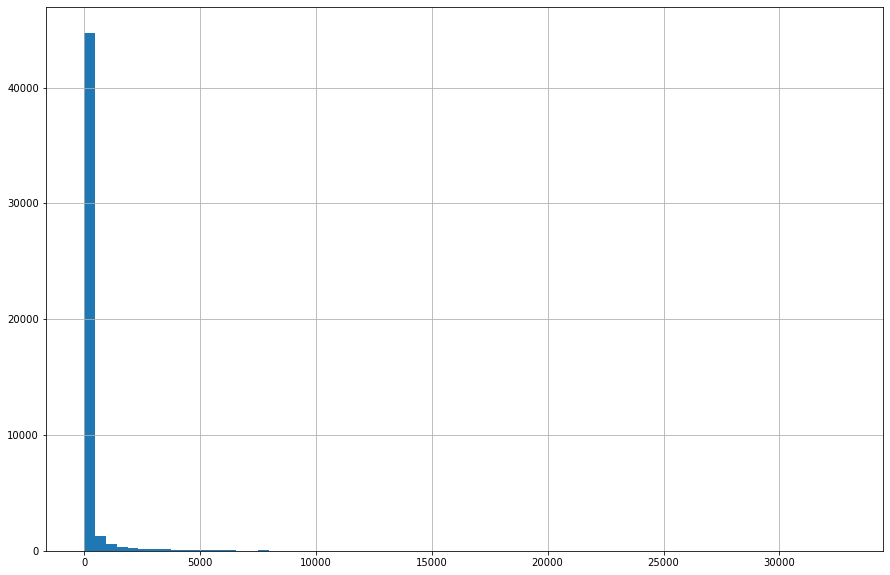

In [21]:
plt.figure(figsize=(15,10))
new_record['rating_counts'].hist(bins=70)

From the output you can see that most movies have received less than 5000 ratings,while the number of movies having more than 10000 ratings is very low

<AxesSubplot:>

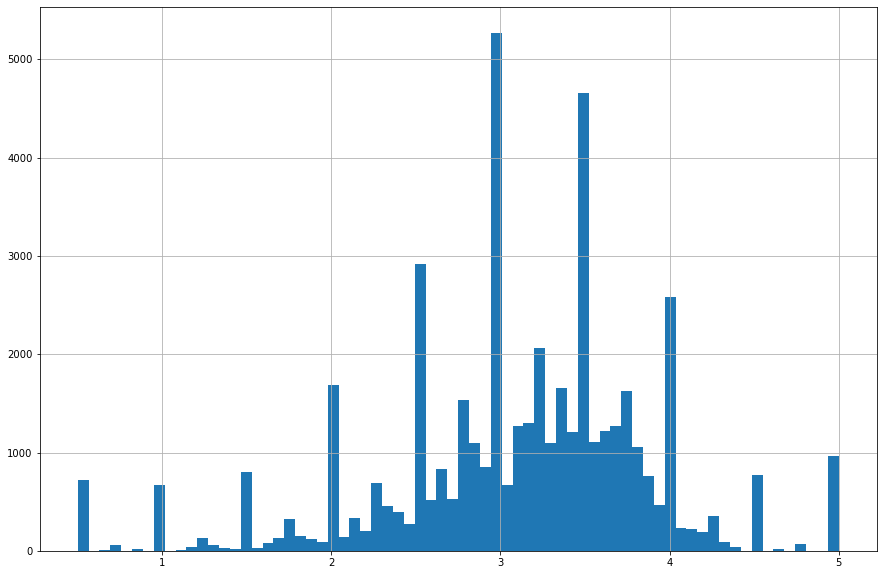

In [22]:
plt.figure(figsize=(15,10))
new_record['rating'].hist(bins=70)

The interger values have taller bars than floating values since most of the users assign rating as interger value that is 1,2,3,4 or 5 furthurmore,it is evident that the data has a weak normal distribution with the mean of 3.5.there are few outliers in the data Movies with higher rating usually have high average rating as well since a good movie is normally well known and well watched by a large number of people.

<Figure size 1080x720 with 0 Axes>

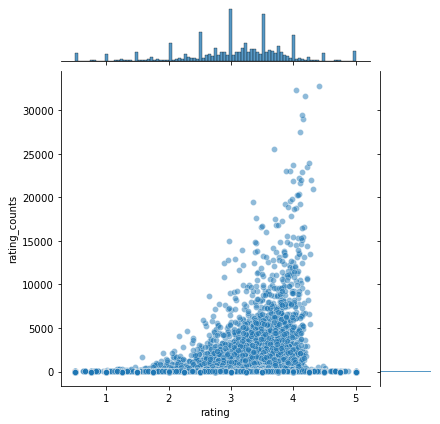

In [23]:
plt.figure(figsize=(15,10))
sns.jointplot(x='rating',y='rating_counts', data=new_record,alpha=0.5)

The graph shows that in general movies with higher average rating have more number of ratings,compared with movies that have lower average ratings

# Feature Engineering

In [23]:
# Load reader and data in surprise friendly format
reader = Reader(rating_scale=(0.5, 5))
train2 = Dataset.load_from_df(train1[['userId', 'movieId', 'rating']], reader)

# Modelling

# Baseline only model


BaselineOnly algorithm predicts the baseline estimate for given user and item.A baseline is a method that uses simple summary statistics, randomness, or machine learning to create predictions for a dataset. You can use these predictions to measure the baseline’s performance (e.g., accuracy)– this metric will then become what you compare any other machine learning algorithm against.

In [24]:
# Baseline Only model

algo_b = BaselineOnly()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_b.fit(trainset)
predictions_b = algo_b.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_b, verbose=True)

Estimating biases using als...
RMSE: 0.8652


0.865238940916113

# SVD model

SVD algorithm is equivalent to Probabilistic Matrix Factorization.
This is a technique that comes from the field of linear algebra and can be used as a data preparation technique to create a projection of a sparse dataset prior to fitting a model.

In [25]:
# SVD model

algo_svd = SVD()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_svd, verbose=True)

RMSE: 0.8263


0.8263111353431118

In [ ]:
algo_nmf = NMF()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_nmf.fit(trainset)
predictions_nmf = algo_nmf.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_nmf, verbose=True)


In [26]:
mydict = {f'SVD': 0.8263,
          f'Baseline Only': 0.8652
         }

i = pd.DataFrame(mydict.items(), columns=['Model', 'RSME'])
i

,Model,RSME
0,SVD,0.8269
1,Baseline Only,0.8650


# Hyperparameter tunning of best model

In [27]:
rating_scale = Reader(rating_scale=(0.5, 5))
train = Dataset.load_from_df(train.drop('timestamp', axis=1), rating_scale)

# Training and validation set split for hypertuning
train_set, val_set = train_test_split(train,
                                      test_size=0.008,
                                      random_state=42)

# Modelling of the SVD hypertuning
svd_algo_hyper = SVD(n_factors=160, 
                     lr_all=0.0085,
                     reg_all=0.02,
                     n_epochs=20,
                     init_std_dev=0.01)
svd_algo_hyper.fit(train_set)

# Predicting on the validation set
svd_hyper_predictions = svd_algo_hyper.test(val_set)

# Convert the predictions to dataframe
#test = pd.DataFrame(predictions)
accuracy.rmse(svd_hyper_predictions)

# Dictionary for the data to log for the SVD tuned model
params = {'model_name': 'SVD_Tuned'}
metrics = {'RMSE': accuracy.rmse(svd_hyper_predictions)}

RMSE: 0.7887
RMSE: 0.7887


In [28]:
pred_svd_hyper = [svd_algo_hyper.predict(row.userId,
                                         row.movieId) for idx,row in test.iterrows()]

# Converting the predictions to a dataframe
test_pred_svd_hyper = pd.DataFrame(pred_svd_hyper)

In [29]:
#renaming the fields of the prediction dataframe
test_pred_svd_hyper.drop(['r_ui', 'details'], axis=1, inplace=True)
test_pred_svd_hyper = test_pred_svd_hyper.rename(columns={'uid':'userId',
                                                          'iid':'movieId',
                                                          'est':'rating'})
test_pred_svd_hyper.head()

,userId,movieId,rating
0,1,2011,3.014343
1,1,4144,4.201016
2,1,5767,3.782267
3,1,6711,4.197016
4,1,7318,2.870485


In [30]:
# Concatenating each userId and movieId to a single Id column for submission
test_pred_svd_hyper['Id'] =  test_pred_svd_hyper['userId'].astype(str).str.zfill(1) + '_' + test_pred_svd_hyper['movieId'].astype(str).str.zfill(1)

In [31]:
svd_hyper_predictions = test_pred_svd_hyper[['Id','rating']]
svd_hyper_predictions.head()

,Id,rating
0,1_2011,3.014343
1,1_4144,4.201016
2,1_5767,3.782267
3,1_6711,4.197016
4,1_7318,2.870485


# Saving model

In [35]:
svd_hyper_predictions[['Id','rating']].to_csv('MM2_submission.csv', index=False)

In [36]:
svd_hyper_predictions

,Id,rating
0,1_2011,3.014343
1,1_4144,4.201016
2,1_5767,3.782267
3,1_6711,4.197016
4,1_7318,2.870485
...,...,...
5000014,162541_4079,3.390925
5000015,162541_4467,4.158285
5000016,162541_4980,2.657099
5000017,162541_5689,2.892333
